In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import k_means
import matplotlib.pyplot as plt
from ctypes import wintypes

In [62]:
import ctypes

In [68]:
GlobalLock = ctypes.windll.kernel32.GlobalLock
GlobalLock.argtypes = [wintypes.UINT]
GlobalLock.restype = wintypes.HANDLE


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
test_df.shape, train_df.shape

((200000, 201), (200000, 202))

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [6]:
train_df.isnull().values.any()

False

In [7]:
test_df.isnull().values.any()

False

In [148]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [150]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.33,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.015,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 15,
    'num_threads': 20,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}

In [151]:
num_round = 100000
folds = StratifiedKFold(n_splits=12, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [152]:
cf = ['var_68','segment_var_1',
 'segment_var_2',
 'segment_var_4',
 'segment_var_5',
 'segment_var_9',
 'segment_var_12',
 'segment_var_16',
 'segment_var_21',
 'segment_var_26',
 'segment_var_29',
 'segment_var_35',
 'segment_var_37',
 'segment_var_40',
 'segment_var_41',
 'segment_var_43',
 'segment_var_44',
 'segment_var_50',
 'segment_var_53',
 'segment_var_55',
 'segment_var_59',
 'segment_var_60',
 'segment_var_80',
 'segment_var_81',
 'segment_var_88',
 'segment_var_92',
 'segment_var_94',
 'segment_var_95',
 'segment_var_98',
 'segment_var_99',
 'segment_var_101',
 'segment_var_126',
 'segment_var_134',
 'segment_var_135',
 'segment_var_137',
 'segment_var_141',
 'segment_var_145',
 'segment_var_150',
 'segment_var_152',
 'grouped_var_68',
 'ind_var_37',
 'ind_var_68',
 'ind_var_98',
 'ind_var_153',
 'ind_var_158',
 'ind_var_131',
 'ind_var_188',
 'ind_var_190',
 'ind_var_9_var_37',
 'ind_var_12_var_13',
 'ind_var_9_var_135',
 'ind_var_76_var_139',
      'probable_day_0.0',
 'probable_day_1.0',
 'probable_day_2.0',
 'probable_day_3.0',
 'probable_day_4.0',
 'probable_day_5.0',
 'probable_day_6.0',
 'probable_day_7.0',
 'probable_month_0.0',
 'probable_month_1.0',
 'probable_month_2.0',
 'probable_month_3.0',
 'probable_month_4.0',
 'probable_month_5.0',
 'probable_month_6.0',
 'probable_month_7.0',
 'probable_month_8.0',
 'probable_month_9.0',
 'probable_month_10.0',
 'probable_month_11.0',
 'probable_month_12.0']

In [153]:

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=1000, early_stopping_rounds = 2500,
                    categorical_feature=cf)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))




Fold 0


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905591	valid_1's auc: 0.884756
[2000]	training's auc: 0.920997	valid_1's auc: 0.89469
[3000]	training's auc: 0.930107	valid_1's auc: 0.898612
[4000]	training's auc: 0.937215	valid_1's auc: 0.900375
[5000]	training's auc: 0.94355	valid_1's auc: 0.901494
[6000]	training's auc: 0.949162	valid_1's auc: 0.901437
[7000]	training's auc: 0.954449	valid_1's auc: 0.901463
Early stopping, best iteration is:
[5426]	training's auc: 0.945954	valid_1's auc: 0.901689
Fold 1


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.90581	valid_1's auc: 0.884474
[2000]	training's auc: 0.921101	valid_1's auc: 0.89353
[3000]	training's auc: 0.930129	valid_1's auc: 0.897307
[4000]	training's auc: 0.937362	valid_1's auc: 0.898059
[5000]	training's auc: 0.943651	valid_1's auc: 0.898408
[6000]	training's auc: 0.94921	valid_1's auc: 0.898379
[7000]	training's auc: 0.954486	valid_1's auc: 0.898343
[8000]	training's auc: 0.959301	valid_1's auc: 0.898109
[9000]	training's auc: 0.963885	valid_1's auc: 0.898058
Early stopping, best iteration is:
[6796]	training's auc: 0.953483	valid_1's auc: 0.898473
Fold 2


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.906594	valid_1's auc: 0.877973
[2000]	training's auc: 0.921707	valid_1's auc: 0.886754
[3000]	training's auc: 0.930919	valid_1's auc: 0.889857
[4000]	training's auc: 0.938007	valid_1's auc: 0.891404
[5000]	training's auc: 0.944211	valid_1's auc: 0.892027
[6000]	training's auc: 0.949803	valid_1's auc: 0.89225
[7000]	training's auc: 0.954979	valid_1's auc: 0.891872
[8000]	training's auc: 0.959902	valid_1's auc: 0.891587
Early stopping, best iteration is:
[5970]	training's auc: 0.949634	valid_1's auc: 0.892275
Fold 3


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905263	valid_1's auc: 0.890514
[2000]	training's auc: 0.920224	valid_1's auc: 0.901445
[3000]	training's auc: 0.929474	valid_1's auc: 0.904886
[4000]	training's auc: 0.936771	valid_1's auc: 0.905844
[5000]	training's auc: 0.943107	valid_1's auc: 0.906352
[6000]	training's auc: 0.948869	valid_1's auc: 0.90637
[7000]	training's auc: 0.954192	valid_1's auc: 0.906445
[8000]	training's auc: 0.959134	valid_1's auc: 0.906679
[9000]	training's auc: 0.963698	valid_1's auc: 0.906213
[10000]	training's auc: 0.967896	valid_1's auc: 0.905798
Early stopping, best iteration is:
[7639]	training's auc: 0.95736	valid_1's auc: 0.906761
Fold 4


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.906025	valid_1's auc: 0.880546
[2000]	training's auc: 0.921082	valid_1's auc: 0.889369
[3000]	training's auc: 0.930291	valid_1's auc: 0.892247
[4000]	training's auc: 0.93746	valid_1's auc: 0.893454
[5000]	training's auc: 0.94373	valid_1's auc: 0.893929
[6000]	training's auc: 0.949309	valid_1's auc: 0.893841
[7000]	training's auc: 0.954432	valid_1's auc: 0.89385
[8000]	training's auc: 0.95934	valid_1's auc: 0.893627
Early stopping, best iteration is:
[5626]	training's auc: 0.947291	valid_1's auc: 0.893996
Fold 5


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905739	valid_1's auc: 0.887091
[2000]	training's auc: 0.920944	valid_1's auc: 0.896666
[3000]	training's auc: 0.93009	valid_1's auc: 0.899332
[4000]	training's auc: 0.937231	valid_1's auc: 0.899847
[5000]	training's auc: 0.94351	valid_1's auc: 0.900287
[6000]	training's auc: 0.949206	valid_1's auc: 0.900448
[7000]	training's auc: 0.954433	valid_1's auc: 0.900014
[8000]	training's auc: 0.95929	valid_1's auc: 0.899879
Early stopping, best iteration is:
[5736]	training's auc: 0.947751	valid_1's auc: 0.900667
Fold 6


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905187	valid_1's auc: 0.8855
[2000]	training's auc: 0.92061	valid_1's auc: 0.895253
[3000]	training's auc: 0.929843	valid_1's auc: 0.898116
[4000]	training's auc: 0.93696	valid_1's auc: 0.899344
[5000]	training's auc: 0.943245	valid_1's auc: 0.89991
[6000]	training's auc: 0.94893	valid_1's auc: 0.899709
[7000]	training's auc: 0.954106	valid_1's auc: 0.899629
Early stopping, best iteration is:
[4951]	training's auc: 0.942965	valid_1's auc: 0.899992
Fold 7


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.904764	valid_1's auc: 0.891087
[2000]	training's auc: 0.920281	valid_1's auc: 0.899801
[3000]	training's auc: 0.929614	valid_1's auc: 0.902316
[4000]	training's auc: 0.936761	valid_1's auc: 0.903204
[5000]	training's auc: 0.943069	valid_1's auc: 0.903762
[6000]	training's auc: 0.948694	valid_1's auc: 0.904043
[7000]	training's auc: 0.953883	valid_1's auc: 0.903771
[8000]	training's auc: 0.958806	valid_1's auc: 0.903975
Early stopping, best iteration is:
[5561]	training's auc: 0.946319	valid_1's auc: 0.904098
Fold 8


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905781	valid_1's auc: 0.884664
[2000]	training's auc: 0.920838	valid_1's auc: 0.892853
[3000]	training's auc: 0.930043	valid_1's auc: 0.896082
[4000]	training's auc: 0.937122	valid_1's auc: 0.897451
[5000]	training's auc: 0.943338	valid_1's auc: 0.897923
[6000]	training's auc: 0.949083	valid_1's auc: 0.89796
[7000]	training's auc: 0.954273	valid_1's auc: 0.89825
[8000]	training's auc: 0.959223	valid_1's auc: 0.898102
[9000]	training's auc: 0.963761	valid_1's auc: 0.897722
Early stopping, best iteration is:
[7040]	training's auc: 0.954481	valid_1's auc: 0.898321
Fold 9


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905459	valid_1's auc: 0.889986
[2000]	training's auc: 0.920649	valid_1's auc: 0.898012
[3000]	training's auc: 0.929671	valid_1's auc: 0.901224
[4000]	training's auc: 0.936856	valid_1's auc: 0.902858
[5000]	training's auc: 0.943262	valid_1's auc: 0.903417
[6000]	training's auc: 0.948943	valid_1's auc: 0.903907
[7000]	training's auc: 0.954208	valid_1's auc: 0.903371
[8000]	training's auc: 0.959099	valid_1's auc: 0.903069
Early stopping, best iteration is:
[5787]	training's auc: 0.947789	valid_1's auc: 0.903934
Fold 10


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905261	valid_1's auc: 0.891678
[2000]	training's auc: 0.920349	valid_1's auc: 0.900839
[3000]	training's auc: 0.929488	valid_1's auc: 0.903801
[4000]	training's auc: 0.93665	valid_1's auc: 0.904594
[5000]	training's auc: 0.942964	valid_1's auc: 0.905008
[6000]	training's auc: 0.948638	valid_1's auc: 0.905219
[7000]	training's auc: 0.954015	valid_1's auc: 0.905359
[8000]	training's auc: 0.95889	valid_1's auc: 0.905222
[9000]	training's auc: 0.963468	valid_1's auc: 0.905205
Early stopping, best iteration is:
[7467]	training's auc: 0.956334	valid_1's auc: 0.905514
Fold 11


C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grouped_var_68', 'ind_var_12_var_13', 'ind_var_131', 'ind_var_153', 'ind_var_158', 'ind_var_188', 'ind_var_190', 'ind_var_37', 'ind_var_68', 'ind_var_76_var_139', 'ind_var_98', 'ind_var_9_var_135', 'ind_var_9_var_37', 'probable_day_0.0', 'probable_day_1.0', 'probable_day_2.0', 'probable_day_3.0', 'probable_day_4.0', 'probable_day_5.0', 'probable_day_6.0', 'probable_day_7.0', 'probable_month_0.0', 'probable_month_1.0', 'probable_month_10.0', 'probable_month_11.0', 'probable_month_12.0', 'probable_month_2.0', 'probable_month_3.0', 'probable_month_4.0', 'probable_month_5.0', 'probable_month_6.0', 'probable_month_7.0', 'probable_month_8.0', 'probable_month_9.0', 'segment_var_1', 'segment_var_101', 'segment_var_12', 'segment_var_126', 'segment_var_134', 'segment_var_135', 'segment_var_137', 'segment_var_141', 'se

Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.905821	valid_1's auc: 0.885794
[2000]	training's auc: 0.920932	valid_1's auc: 0.89456
[3000]	training's auc: 0.930197	valid_1's auc: 0.897799
[4000]	training's auc: 0.937294	valid_1's auc: 0.898752
[5000]	training's auc: 0.943597	valid_1's auc: 0.899192
[6000]	training's auc: 0.949349	valid_1's auc: 0.899645
[7000]	training's auc: 0.954575	valid_1's auc: 0.899403
[8000]	training's auc: 0.959422	valid_1's auc: 0.899313
Early stopping, best iteration is:
[6210]	training's auc: 0.950455	valid_1's auc: 0.899804
CV score: 0.90040 


In [154]:
submission = pd.DataFrame({"ID_code": test_df.ID_code.values})
submission["target"] = predictions
submission.to_csv("submission_v6.csv", index=False)

In [45]:
import seaborn as sns

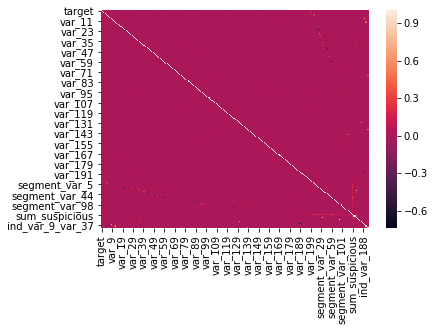

In [46]:
sns.heatmap(train_df.corr())

In [60]:
train_df.columns[np.argsort(clf.feature_importance())[::-1]]

Index(['var_11', 'var_32', 'var_92', 'var_119', 'var_76', 'var_163', 'var_172',
       'var_131', 'var_120', 'var_7',
       ...
       'segment_var_135', 'segment_var_88', 'segment_var_145',
       'segment_var_29', 'segment_var_134', 'segment_var_94', 'segment_var_21',
       'segment_var_98', 'var_101', 'var_66'],
      dtype='object', length=241)

In [68]:
len(train_df.columns)

243

In [81]:
train_df.columns[(np.argsort(clf.feature_importance())[::-1])][:60]

Index(['var_11', 'var_32', 'var_92', 'var_119', 'var_76', 'var_163', 'var_172',
       'var_131', 'var_120', 'var_7', 'var_0', 'var_144', 'grouped_var_68',
       'var_69', 'var_73', 'var_20', 'var_171', 'var_125', 'var_116',
       'var_175', 'var_188', 'var_51', 'var_168', 'var_137', 'var_79',
       'var_162', 'var_74', 'var_33', 'var_145', 'var_4', 'var_31', 'var_19',
       'var_108', 'var_113', 'var_196', 'var_97', 'var_65', 'var_190',
       'var_147', 'var_182', 'var_152', 'target', 'var_78', 'var_54',
       'var_121', 'var_90', 'var_34', 'var_24', 'var_155', 'var_68', 'var_135',
       'var_146', 'var_85', 'var_84', 'var_42', 'var_38', 'var_139', 'var_170',
       'var_87', 'var_184'],
      dtype='object')

In [72]:
np.argsort(clf.feature_importance())[::-1]

array([ 13,  34,  94, 121,  78, 165, 174, 133, 122,   9,   2, 146, 240,
        71,  75,  22, 173, 127, 118, 177, 190,  53, 170, 139,  81, 164,
        76,  35, 147,   6,  33,  21, 110, 115, 198,  99,  67, 192, 149,
       184, 154,   1,  80,  56, 123,  92,  36,  26, 157,  70, 137, 148,
        87,  86,  44,  40, 141, 172,  89, 186, 163, 155, 191, 188,  18,
         0, 119,  49, 199, 109,  20, 131, 195, 114, 112, 180,  95, 116,
       197, 145, 162, 128,   5, 130, 106,  52,  51, 132, 107, 151, 179,
        31,  28, 175,  24,  90,  48, 135, 144,  32, 111, 193,  82, 150,
        74,  58,  93,  85, 104, 125,   8,  11,  83, 156,  77, 159, 105,
        15, 134, 196,  45, 167,  66, 194, 178,  55,  69,  97,  88, 168,
       138, 171,  54,  63,  72, 102,  16, 142, 160, 113,  62, 187,  50,
        57, 101,  64,  60, 140,  14,  59, 117, 153, 181,   4,   3, 120,
        79, 143,  46,  96,  19, 189, 183,  61,  84,  65,  41, 152, 129,
        73,  98,  27,  42, 100,  37,  47, 182,  39,  30, 136,  1

In [82]:
np.sort(clf.feature_importance())

array([  0,   2,   4,   4,   4,   5,   5,   6,   7,   8,  10,  11,  11,
        12,  12,  14,  16,  17,  17,  18,  18,  20,  26,  26,  29,  30,
        32,  37,  39,  40,  43,  44,  46,  46,  50,  50,  51,  56,  56,
        61,  70,  71, 125, 126, 150, 162, 164, 179, 193, 197, 248, 265,
       287, 292, 293, 295, 297, 299, 302, 305, 307, 308, 309, 310, 316,
       318, 320, 321, 327, 328, 330, 333, 333, 335, 336, 337, 342, 344,
       344, 345, 345, 346, 350, 350, 352, 357, 361, 362, 364, 364, 364,
       365, 373, 376, 382, 382, 384, 385, 387, 389, 394, 394, 396, 399,
       400, 402, 410, 412, 412, 414, 414, 418, 430, 432, 433, 433, 433,
       436, 436, 438, 438, 439, 445, 445, 446, 446, 448, 452, 453, 456,
       457, 460, 461, 466, 468, 473, 474, 475, 477, 479, 479, 480, 487,
       490, 492, 492, 495, 496, 499, 499, 501, 501, 503, 504, 510, 511,
       512, 514, 516, 517, 518, 519, 520, 522, 524, 525, 525, 526, 527,
       530, 530, 531, 531, 532, 533, 534, 534, 537, 539, 540, 54

In [83]:
clf.feature_importance()

array([534, 568, 623, 361, 362, 516, 584, 302, 457, 625, 307, 456, 193,
       664, 373, 445, 400, 293, 534, 345, 530, 582, 613, 164, 495,  51,
       559, 328, 499, 295, 309, 499, 480, 584, 663, 587, 560, 320, 305,
       310, 554, 336, 327, 126, 554, 438, 350, 318, 492, 532, 387, 510,
       511, 593, 412, 433, 565, 385, 473, 365, 382, 344, 394, 412, 382,
       337, 436, 575,   0, 433, 557, 615, 410, 333, 474, 615, 587, 448,
       648, 352, 568, 589, 477, 453, 342, 466, 555, 556, 430, 548, 492,
       150, 560, 468, 651, 524, 346, 432, 330, 576, 321, 384, 402,   2,
       461, 446, 512, 503, 179, 531, 579, 479, 525, 394, 526, 579, 522,
       364, 597, 533, 357, 648, 630, 563, 297, 460, 287, 598, 517, 333,
       514, 530, 504, 630, 445, 490, 308, 556, 414, 589, 376, 551, 399,
       350, 487, 519, 621, 586, 556, 574, 475, 501, 335, 364, 573, 540,
       452, 558, 265, 446, 396,  11, 518, 541, 589, 639, 162, 438, 418,
       197, 593, 414, 550, 600, 635, 496, 292, 595, 433, 501, 52

In [69]:
submission.head()

,ID_code,target
0,test_0,0.104137
1,test_1,0.140078
2,test_2,0.151005
3,test_3,0.133428
4,test_4,0.058897


# Data explonatory

In [88]:
def an(x):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    sns.distplot(train_df[x],bins=200)
    
    plt.subplot(1,3,2)
    sns.distplot(train_df[train_df['target']==1][x],bins=200)
    plt.subplot(1,3,3)
    sns.distplot(train_df[train_df['target']==0][x],bins=200)
    

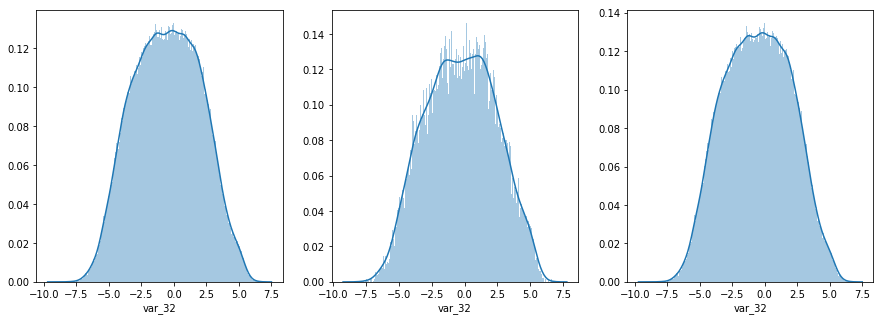

In [94]:
an('var_32')

In [164]:
def bn(x,l,r):
    sns.distplot(train_df[(train_df[x]>l)&(train_df[x]<r)][x],bins=200)

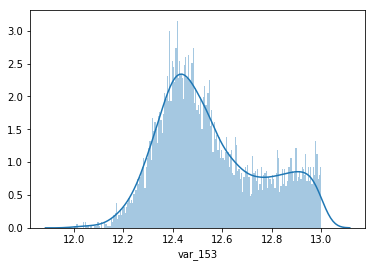

In [373]:
bn('var_153',12,13)

In [8]:
suspisious_segments = {
    'var_1':[7,8.5],
    'var_2':[12,13],
    'var_4':[13.7,14.8],
    'var_5':[9,14],
    'var_9':[7.5,8],
    'var_12':[13.525,13.575],
    'var_16':[10.5,11],
    'var_21':[0,10],
    'var_26':[6,11],
    'var_29':[11,11.8],
    'var_35':[12.5,14.5],
    'var_37':[11,11.25],
    'var_40':[11,13],
    'var_41':[8.5,9.3],
    'var_43':[10.85,11],
    'var_44':[-6,-1],
    'var_50':[11.3,11.5],
    'var_53':[7.75,7.825],
    'var_55':[8,12],
    'var_59':[7.15,8],
    'var_60':[10,14],
    'var_80':[1.5,2.5],
    'var_81':[8.9,9.3],
    'var_88':[3,4],
    'var_92':[3.5,4.7],
    'var_94':[10,10.5],
    'var_95':[1.2,1.5],
    'var_98':[0,0.3],
    'var_99':[3.75,3.9],
    'var_101':[1.55,2.3],
    'var_126':[11.25,11.75],
    'var_134':[8.7,9.5],
    'var_135':[12,14],
    'var_137':[1,3.8],
    'var_141':[3.7,4.5],
    'var_145':[13,14.5],
    'var_150':[11,12.2],
    'var_152':[12.2,12.6]
}

In [9]:
clustered_categories = k_means(np.reshape(train_df['var_68'].value_counts().values,(451,1)),
                 n_clusters=5)[1]

In [10]:
clustered_categories_dict = dict(zip(train_df['var_68'].value_counts().index,clustered_categories))

In [11]:
train_df['var_1'].map(lambda x: 1 if x >=suspisious_segments['var_1'][0]
                                 and x <=suspisious_segments['var_1'][1] else 0).value_counts()

0    196970
1      3030
Name: var_1, dtype: int64

In [12]:
for col in suspisious_segments:
    train_df['segment_'+col] = train_df[col].map(lambda x: 1 if x >=suspisious_segments[col][0]
                                 and x <=suspisious_segments[col][1] else 0)

In [13]:
train_df['grouped_var_68'] = train_df['var_68'].map(clustered_categories_dict)

In [14]:
for col in suspisious_segments:
    test_df['segment_'+col] = test_df[col].map(lambda x: 1 if x >=suspisious_segments[col][0]
                                 and x <=suspisious_segments[col][1] else 0)

In [15]:
test_df['grouped_var_68'] = test_df['var_68'].map(clustered_categories_dict)

In [16]:
train_df['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [ ]:
'var_37'>=10.75
'var_68'<=5.003
'var_12' > 14 & 'var_13' > 12
'var_98' <= 0.3
'var_135' >= 11 & 'var_9' < 2.5
'var_153' < 13
'var_158' < 3
'var_76' > 5 & 'var_139' > 8
'var_131' > 1.1
'var_188' < 8
'var_190' < 0
-20 + 3.5 * 'var_9' - 'var_37' > 0

# Top columns by feature importance for pair-plots

In [96]:
columns_top = ['var_11', 'var_32', 'var_92', 'var_119', 'var_76', 'var_163', 'var_172',
       'var_131', 'var_120', 'var_7', 'var_0', 'var_144', 'grouped_var_68',
       'var_69', 'var_73', 'var_20', 'var_171', 'var_125', 'var_116',
       'var_175', 'var_188', 'var_51', 'var_168', 'var_137', 'var_79',
       'var_162', 'var_74', 'var_33', 'var_145', 'var_4', 'var_31', 'var_19',
       'var_108', 'var_113', 'var_196', 'var_97', 'var_65', 'var_190',
       'var_147', 'var_182', 'var_152', 'target', 'var_78', 'var_54',
       'var_121', 'var_90', 'var_34', 'var_24', 'var_155', 'var_68', 'var_135',
       'var_146', 'var_85', 'var_84', 'var_42', 'var_38', 'var_139', 'var_170',
       'var_87', 'var_184']

In [ ]:
for i in list(range(2,203)):
    for j in list(range(i,203)):
        plt.figure(figsize=(10,8))
        plt.xlabel(cols[i])
        plt.ylabel(cols[j])
        plt.scatter(train_df[cols[i]],train_df[cols[j]],c=train_df['target'],s=0.5)
        plt.savefig('pictures/'+cols[i]+'_'+cols[j]+'.png')

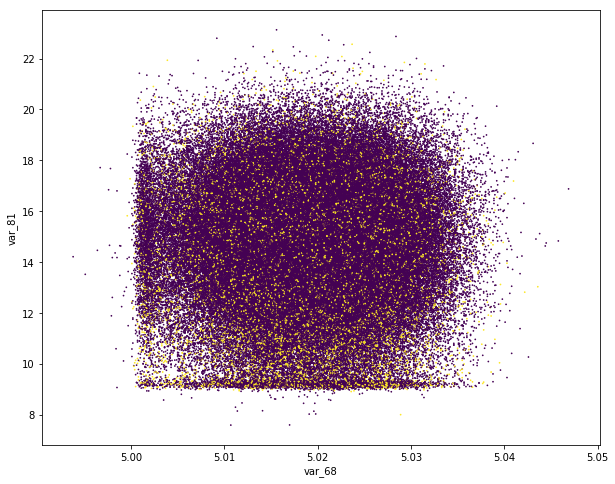

In [536]:
plt.figure(figsize=(10,8))
plt.xlabel('var_68')
plt.ylabel('var_81')
plt.scatter(train_df['var_68'],train_df['var_81'],c=train_df['target'],s=0.5)
plt.savefig('abc.png')

# Generation of indicators of bi-modal intervals

In [ ]:
train_df['sum_suspicious'] = np.sum(train_df.iloc[:,202:-1],axis=1)

In [18]:
test_df['sum_suspicious'] = np.sum(test_df.iloc[:,202:-1],axis=1)

In [19]:
mean_target_68 = train_df.groupby('var_68').agg({'target':'mean','sum_suspicious':'count'})

In [20]:
mean_target_68['mean_target'] = 0

In [21]:
mean_target_68.loc[mean_target_68[mean_target_68['sum_suspicious']>=10].index,'mean_target'] =\
    mean_target_68.loc[mean_target_68[mean_target_68['sum_suspicious']>=10].index,'target']

In [22]:
mean_target_68['mean_target_5'] = 0

In [23]:
mean_target_68.loc[mean_target_68[mean_target_68['sum_suspicious']>=5].index,'mean_target_5'] =\
    mean_target_68.loc[mean_target_68[mean_target_68['sum_suspicious']>=5].index,'target']

In [24]:
mean_target_68['mean_target_3'] = 0

In [25]:
mean_target_68.loc[mean_target_68[mean_target_68['sum_suspicious']>=3].index,'mean_target_3'] =\
    mean_target_68.loc[mean_target_68[mean_target_68['sum_suspicious']>=3].index,'target']

In [26]:
mean_target_68.head()

,target,sum_suspicious,mean_target,mean_target_5,mean_target_3
var_68,,,,,
4.9938,0.0,1,0.0,0.0,0.0
4.9951,0.0,1,0.0,0.0,0.0
4.9964,0.0,1,0.0,0.0,0.0
4.9967,0.0,1,0.0,0.0,0.0
4.9976,0.0,1,0.0,0.0,0.0


In [34]:
train_df.drop('mean_target',axis=1,inplace=True)
test_df.drop('mean_target',axis=1,inplace=True)

In [27]:
train_df = train_df.join(mean_target_68[['mean_target','mean_target_5','mean_target_3']],on='var_68')

In [28]:
test_df = test_df.join(mean_target_68[['mean_target','mean_target_5','mean_target_3']],on='var_68')

In [29]:
train_df['ind_var_37'] = train_df['var_37'].map(lambda x: 1 if x>=10.75 else 0)
train_df['ind_var_68'] = train_df['var_68'].map(lambda x: 1 if x<=5.003 else 0)
train_df['ind_var_98'] = train_df['var_98'].map(lambda x: 1 if x<=0.3 else 0)
train_df['ind_var_153'] = train_df['var_153'].map(lambda x: 1 if x<13 else 0)
train_df['ind_var_158'] = train_df['var_158'].map(lambda x: 1 if x<=3 else 0)
train_df['ind_var_131'] = train_df['var_131'].map(lambda x: 1 if x>1.1 else 0)
train_df['ind_var_188'] = train_df['var_188'].map(lambda x: 1 if x<8 else 0)
train_df['ind_var_190'] = train_df['var_190'].map(lambda x: 1 if x<0 else 0)
train_df['ind_var_9_var_37'] = (train_df['var_9'] * 3.5 - 20 - train_df['var_37']).map(lambda x: 1 if x>0 else 0)

train_df['ind_var_12_var_13'] = 0
train_df.loc[train_df[(train_df['var_12']> 14)&(train_df['var_13']> 12)].index,'ind_var_12_var_13'] = 1

train_df['ind_var_9_var_135'] = 0
train_df.loc[train_df[(train_df['var_9']< 2.5)&(train_df['var_135']>= 11)].index,'ind_var_9_var_135'] = 1

train_df['ind_var_76_var_139'] = 0
train_df.loc[train_df[(train_df['var_76']> 5)&(train_df['var_139']>= 8)].index,'ind_var_76_var_139'] = 1

In [30]:
test_df['ind_var_37'] = test_df['var_37'].map(lambda x: 1 if x>=10.75 else 0)
test_df['ind_var_68'] = test_df['var_68'].map(lambda x: 1 if x<=5.003 else 0)
test_df['ind_var_98'] = test_df['var_98'].map(lambda x: 1 if x<=0.3 else 0)
test_df['ind_var_153'] = test_df['var_153'].map(lambda x: 1 if x<13 else 0)
test_df['ind_var_158'] = test_df['var_158'].map(lambda x: 1 if x<=3 else 0)
test_df['ind_var_131'] = test_df['var_131'].map(lambda x: 1 if x>1.1 else 0)
test_df['ind_var_188'] = test_df['var_188'].map(lambda x: 1 if x<8 else 0)
test_df['ind_var_190'] = test_df['var_190'].map(lambda x: 1 if x<0 else 0)
test_df['ind_var_9_var_37'] = (test_df['var_9'] * 3.5 - 20 - test_df['var_37']).map(lambda x: 1 if x>0 else 0)

test_df['ind_var_12_var_13'] = 0
test_df.loc[test_df[(test_df['var_12']> 14)&(test_df['var_13']> 12)].index,'ind_var_12_var_13'] = 1

test_df['ind_var_9_var_135'] = 0
test_df.loc[test_df[(test_df['var_9']< 2.5)&(test_df['var_135']>= 11)].index,'ind_var_9_var_135'] = 1

test_df['ind_var_76_var_139'] = 0
test_df.loc[test_df[(test_df['var_76']> 5)&(test_df['var_139']>= 8)].index,'ind_var_76_var_139'] = 1

In [ ]:
'var_37'>=10.75
'var_68'<=5.003

'var_98' <= 0.3

'var_153' < 13
'var_158' < 3

'var_131' > 1.1
'var_188' < 8
'var_190' < 0
-20 + 3.5 * 'var_9' - 'var_37' > 0
'var_12' > 14 & 'var_13' > 12
'var_135' >= 11 & 'var_9' < 2.5
'var_76' > 5 & 'var_139' > 8

In [52]:
import xgboost as xgb

In [53]:
xgb_classif = xgb.XGBClassifier(n_estimators=300)

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

In [55]:
def roc_auc_scorer_f(y_true, y_pred):
    return roc_auc_score(y_true, y_pred[:, 1])

In [56]:
roc_auc_scorer = metrics.make_scorer(roc_auc_scorer_f,needs_proba=True)

In [57]:
xgb_classif.fit(train_df.loc[:1000,features],train_df.loc[:1000,'target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [58]:
#tmp = cross_val_score(xgb_classif,train_df[features],train_df['target'],cv=3,scoring=roc_auc_scorer,verbose=5,n_jobs=4)

In [59]:
sk_fold = StratifiedKFold(n_splits=12,random_state=42)

In [60]:
xgb_classif = xgb.XGBClassifier(max_depth=2,n_estimators=250,learning_rate=0.015,random_state=42,
                                min_child_weight=10,eval_metric='auc')

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
log_reg = LogisticRegression()

In [ ]:
param = {
'bagging_freq': 5,
'bagging_fraction': 0.33,
'boost_from_average':'false',
'boost': 'gbdt',
'feature_fraction': 0.05,
'learning_rate': 0.015,
'max_depth': -1,
'metric':'auc',
'min_data_in_leaf': 100,
'min_sum_hessian_in_leaf': 10.0,
'num_leaves': 15,
'num_threads': 20,
'tree_learner': 'serial',
'objective': 'binary',
'verbosity': 1
}

In [78]:
frame = pd.DataFrame(columns=['columns','nunique'])

In [79]:
for col_1 in range(0,200):
    for col_2 in range(col_1,200):
        l = len(train_df[['var_'+str(col_1),'var_'+str(col_2)]].drop_duplicates())
        frame = frame.append({'columns':'var_'+str(col_1)+'_var_'+str(col_2),'nunique':l},ignore_index=True)

In [82]:
frame.sort_values(by=['nunique']).to_excel('hash_looking.xlsx')

In [140]:
train_df.drop(labels=['target_day_feature','target_month_feature'],axis=1,inplace=True)

# Timestamp features creation

In [137]:
train_df['probable_day'] = np.round(train_df['var_68']/0.0001 % 7)
test_df['probable_day'] = np.round(test_df['var_68']/0.0001 % 7)

In [141]:
train_df = train_df.join(train_df.groupby('probable_day').agg({'target':'mean'}),on='probable_day',rsuffix='_day_feature')
test_df = test_df.join(train_df.groupby('probable_day').agg({'target':'mean'}),on='probable_day',rsuffix='_day_feature')

In [142]:
train_df['probable_month'] = np.round((train_df['var_68']/0.0001 - (train_df['var_68']/0.0001).min())%31 % 12)
test_df['probable_month'] = np.round((test_df['var_68']/0.0001 - (test_df['var_68']/0.0001).min())%31 % 12)


In [143]:
train_df = train_df.join(train_df.groupby('probable_month').agg({'target':'mean'}),on='probable_month',rsuffix='_month_feature')
test_df = test_df.join(train_df.groupby('probable_month').agg({'target':'mean'}),on='probable_month',rsuffix='_month_feature')

In [144]:
train_df['probable_day'].unique()

array([3., 2., 6., 4., 1., 7., 5., 0.])

In [146]:
train_df = pd.get_dummies(train_df,columns=['probable_day','probable_month'])
test_df = pd.get_dummies(test_df,columns=['probable_day','probable_month'])

###### We tried to bin indexes in order to consider it as a time series, but it didn't give result

In [209]:
train_df['bin'] = train_df.index // 1000

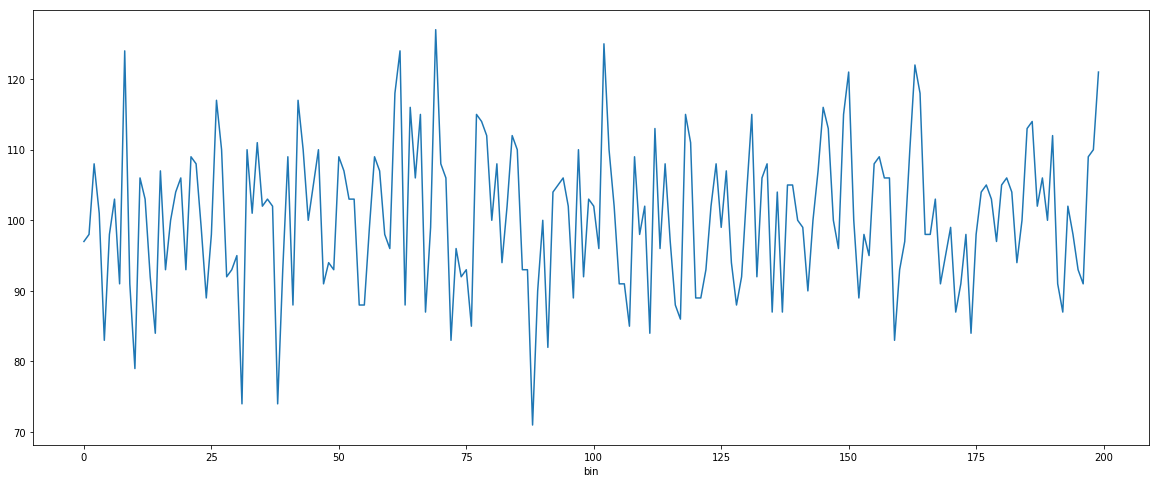

In [210]:

train_df.groupby('bin')['target'].sum().plot(figsize=(20,8))